# Proposed Commissioning Instrument (CI) Tiling

In [1]:
import numpy as np
import healpy as hp
from astropy.table import Table
from astropy.io import fits
import fitsio
import desimodel.io
import desimodel.footprint
from glob import glob

In [2]:
#- For interactive plots
import bokeh.plotting as bk
bk.output_notebook()

Loading BokehJS ...

In [3]:
#- for histograms...
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load standard DESI tiling pattern from desimodel

Use all PASS=0 tiles to cover full sky without extra dithers.

In [4]:
alltiles = desimodel.io.load_tiles(onlydesi=False, extra=True)
tiles = alltiles[alltiles['PASS'] == 0]

## Sub-sample tiles that are ~5 degrees apart

In [5]:
def angdist(ra1, dec1, ra2, dec2):
    '''
    Returns angular distance in degrees between (ra1,dec1) and (ra2,dec2),
    both measured in degrees.
    '''
    dec1 = np.radians(dec1)
    dec2 = np.radians(dec2)
    dd = dec1 - dec2
    dr = np.radians(ra1 - ra2)
    #- Haversine formula https://en.wikipedia.org/wiki/Haversine_formula
    r = 2 * np.arcsin(np.sqrt(
        np.sin(dd/2)**2 + (np.cos(dec1) * np.cos(dec2) * np.sin(dr/2)**2)
        ))
    return np.degrees(r)

In [6]:
keep = np.zeros(len(tiles), dtype=bool)
keep[0] = True
for i in range(1, len(tiles)):
    ra = tiles['RA'][keep]
    dec = tiles['DEC'][keep]
    r = angdist(tiles['RA'][i], tiles['DEC'][i], ra, dec)
    if np.min(r) > 5:
        keep[i] = True

keep &= tiles['DEC'] > -30
        
citiles = Table(tiles[keep])

In [7]:
np.max(alltiles['TILEID'])

57620

In [8]:
#- Give CI tiles new TILEIDs, making sure they don't overlap with the standard tiles
citileid_min = ((np.max(alltiles['TILEID'])+1001)//1000)*1000
citiles['CENTERID'] = citiles['TILEID']
citiles['TILEID'] = np.arange(citileid_min, citileid_min+len(citiles), dtype=alltiles['TILEID'].dtype)
print('Assigning CI TILEIDs {}-{}'.format(np.min(citiles['TILEID']), np.max(citiles['TILEID'])))
assert np.all(~np.in1d(citiles['TILEID'], alltiles['TILEID']))

#- Update PROGRAM
citiles['PROGRAM'] = 'CI'

Assigning CI TILEIDs 58000-58994


In [9]:
def plottiles(tiles, color='gray', fig=None, show=True, size=3):
    if fig is None:
        fig = bk.figure(width=600, height=300)
    fig.circle(tiles['RA'], tiles['DEC'], size=size, fill_color=color, color=color)
    fig.xaxis.axis_label = 'RA'
    fig.yaxis.axis_label = 'DEC'
    if show:
        bk.show(fig)
    return fig

fig = plottiles(citiles, color='lightgray', show=False)
fig = plottiles(citiles[citiles['IN_DESI']>0], color='royalblue', fig=fig, show=True, size=5)

In [12]:
outdir = os.getenv('SCRATCH') + '/desi/ci/tiles/v2'
os.makedirs(outdir, exist_ok=True)

In [31]:
citiles.meta['EXTNAME'] = 'TILES'
citiles.write(outdir+'/ci-tiles-v2.fits', overwrite=True)

## Create GFA candidate targets

Run these in a cori terminal; it takes 20-30 minutes.

```
source /project/projectdirs/desi/software/desi_environment.sh master

salloc -N 1 -C haswell -t 01:00:00 --qos interactive -L SCRATCH,project

export GAIA_DIR="/project/projectdirs/desi/target/gaia_dr2"

export LSDIR='/project/projectdirs/cosmo/data/legacysurvey/dr7/sweep/7.1/'
export LSDIR2='/project/projectdirs/desi/target/gaia_dr2_match_dr6/dr6/sweep/6.0/'
mkdir -p $SCRATCH/desi/ci/tiles/v2

# OLD
# select_cmx_gfas $LSDIR $SCRATCH/desi/ci/tiles/v2/ci-targets-v2.fits -s2 $LSDIR2 --maglim 18.0 --mindec -30 --mingalb 20

# NEW
select_gfas --cmx $LSDIR $SCRATCH/desi/ci/tiles/v2/ci-targets-v2.fits -s2 $LSDIR2 --maglim 18.0 --mindec -30 --mingalb 20

```

## Load GFA targets

In [14]:
# targfile = '/project/projectdirs/desi/target/catalogs/dr7.1/0.27.0/gfas-dr7.1-0.27.0.fits'
# targfile = '/global/cscratch1/sd/adamyers/cmx-gfas-blat.fits'
targfile = outdir+ '/ci-targets-v2.fits'
targets = fitsio.read(targfile, 1)
print(len(targets))

36408878


In [16]:
set(targets['MORPHTYPE'])

{b'COMP', b'DEV ', b'EXP ', b'PSF ', b'REX ', b'U   '}

In [15]:
#- onlyGaia = no morphtype from legacy surveys DR6 or DR7.1
onlyGaia = (targets['MORPHTYPE'] == b'U   ')
print(np.count_nonzero(onlyGaia), 'targets with only Gaia morphologies')
print(np.count_nonzero(~onlyGaia), 'targets with DR6/7.1 morphologies')

13909687 targets with only Gaia morphologies
22499191 targets with DR6/7.1 morphologies


In [17]:
# From Dustin via Adam:
#     gaia.pointsource = np.logical_or(
#         (gaia.G <= 19.) * (gaia.astrometric_excess_noise < 10.**0.5),
#         (gaia.G >= 19.) * (gaia.astrometric_excess_noise < 10.**(0.5 + 0.2*(gaia.G - 19.))))

isPSF = (targets['MORPHTYPE'] == b'PSF ')
gaia_g = targets['GAIA_PHOT_G_MEAN_MAG']
isGPSF = (gaia_g<=19.0) & (targets['GAIA_ASTROMETRIC_EXCESS_NOISE'] < 10**0.5)
isGPSF |= (gaia_g>=19.0) & (targets['GAIA_ASTROMETRIC_EXCESS_NOISE'] < 10**(0.5 + 0.2*(gaia_g - 19.0)))

In [18]:
print('Targets with both LS and Gaia info', np.count_nonzero(~onlyGaia))
print('Gaia and LS agree PSF:', np.count_nonzero(~onlyGaia & isPSF & isGPSF))
print('Gaia PSF and LS GAL  :', np.count_nonzero(~onlyGaia & ~isPSF & isGPSF))
print('Gaia GAL and LS PSF  :', np.count_nonzero(~onlyGaia & isPSF & ~isGPSF))
print('Gaia and LS agree PSF:', np.count_nonzero(~onlyGaia & ~isPSF & ~isGPSF))

Targets with both LS and Gaia info 22499191
Gaia and LS agree PSF: 19764750
Gaia PSF and LS GAL  : 2644214
Gaia GAL and LS PSF  : 58784
Gaia and LS agree PSF: 31443


In [19]:
targets['MORPHTYPE'][onlyGaia & isGPSF] = b'GPSF'

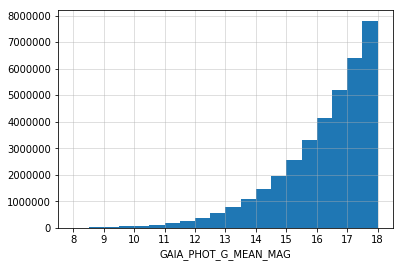

In [21]:
hist(targets['GAIA_PHOT_G_MEAN_MAG'], 20, (8, 18))
xlabel('GAIA_PHOT_G_MEAN_MAG')
# hist(targets['GAIA_PHOT_G_MEAN_MAG'][isGPSF], 20, (8, 18), alpha=0.5)
xticks(range(8, 19))
grid()
# savefig('plots/ci-target-gaia-mags.png')

In [22]:
fig = bk.figure(width=600, height=300)
fig.circle(targets['RA'][0::5000], targets['DEC'][0::5000], alpha=0.2)
fig.xaxis.axis_label = 'RA'
fig.yaxis.axis_label = 'DEC'
fig.title.text = '0.02% of CI Candidate Targets'
bk.show(fig)

## Select GFA targets for those tiles

**NOTE**: `ci-corners.ecsv` will be added to desimodel after it is vetted, but for convenience it
is included here with this notebook.

In [23]:
import desimodel.focalplane

In [24]:
ci_corners = Table.read('ci-corners.ecsv', format='ascii.ecsv')
ciloc = desimodel.focalplane.GFALocations(ci_corners)

In [25]:
tile_indices = desimodel.footprint.find_points_in_tiles(citiles, targets['RA'], targets['DEC'], radius=1.7)

In [26]:
badtileids = list()
for i in range(len(citiles)):
#     if citiles['IN_DESI'][i] == 0:
#         continue

    tileid = citiles['TILEID'][i]
    ii = tile_indices[i]
    if len(ii) == 0:
        ### print('Skipping tile ID {} with no input targets'.format(tileid))
        badtileids.append(tileid)
        continue
    else:
        # print(tileid)
        pass

    telra, teldec = citiles['RA'][i], citiles['DEC'][i]
    citargets = ciloc.targets_on_gfa(telra, teldec, targets[ii])
    
    #- Copied & modified from fiberassign; should refactor that
    flag = np.ones(len(citargets), dtype="i2")
    ii = (citargets["MORPHTYPE"] == "PSF ") | (citargets["MORPHTYPE"] == "GPSF")
    if np.count_nonzero(ii) == 0:
        print("ERROR: no good GFA targets for "
                  "ETC/GUIDE/FOCUS on tile {}".format(tileid))

    flag[ii] = 0
    citargets["ETC_FLAG"] = flag
    citargets["GUIDE_FLAG"] = flag
    citargets["FOCUS_FLAG"] = flag

    citargets.meta['EXTNAME'] = 'GFA_TARGETS'
    citargets.meta['TILEID'] = tileid
    outfile = os.path.join(outdir, 'citile-{:06d}.fits'.format(tileid))
    citargets.write(outfile, overwrite=True)

ERROR: no good GFA targets for ETC/GUIDE/FOCUS on tile 58017
ERROR: no good GFA targets for ETC/GUIDE/FOCUS on tile 58019
ERROR: no good GFA targets for ETC/GUIDE/FOCUS on tile 58647
ERROR: no good GFA targets for ETC/GUIDE/FOCUS on tile 58661
ERROR: no good GFA targets for ETC/GUIDE/FOCUS on tile 58777


In [27]:
fig = plottiles(citiles, color='lightgray', show=False)
# fig = plottiles(citiles[citiles['IN_DESI']>0], color='royalblue', fig=fig, show=False, size=4)
ii = np.in1d(citiles['TILEID'], badtileids)
fig = plottiles(citiles[~ii], color='navy', fig=fig, show=False, size=5)
fig.title.text = 'CI tiles covered by targets'
bk.show(fig)

## Study star coverage

In [28]:
from collections import Counter
def count_stars(targets):
    ii = targets['GUIDE_FLAG'] == 0
    gfa_loc = targets['GFA_LOC'][ii]
    nstars = list()
    for i in range(5):
        nstars.append(np.count_nonzero(gfa_loc == i+1))
    return np.min(nstars), np.median(nstars), np.mean(nstars), np.sum(nstars)

tilefiles = sorted(glob(outdir+'/citile-*.fits'))

hastilefile = np.zeros(len(citiles), dtype=bool)
nstars_min = np.zeros(len(citiles), dtype=int)
nstars_median = np.zeros(len(citiles), dtype=int)
nstars_mean = np.zeros(len(citiles), dtype=int)
nstars_tot = np.zeros(len(citiles), dtype=int)

for i, tileid in enumerate(citiles['TILEID']):
    filename = '{}/citile-{:06d}.fits'.format(outdir, tileid)
    try:
        x = fitsio.read(filename)
        hastilefile[i] = True
        nmin, nmedian, nmean, ntot = count_stars(x)
        nstars_min[i] = nmin
        nstars_median[i] = nmedian
        nstars_mean[i] = nmean
        nstars_tot[i] = ntot
    except OSError:
        pass

In [29]:
import bokeh.palettes
import bokeh.transform
from bokeh.models import ColorBar, LinearColorMapper

In [30]:
def plot_nstars(nstars, title, n=20):
    # colormap = bokeh.palettes.RdYlGn10[-1::-1]
    # colormap = bokeh.palettes.Category20b[n]
    # colormap = bokeh.palettes.viridis(n)

    colormap = bokeh.palettes.RdYlGn10[-1::-1]

    bad = (nstars == 0) & hastilefile

    colors = np.array(colormap)[nstars.clip(0,n-1)//2]
    fig = plottiles(citiles[hastilefile], color=colors[hastilefile], fig=None, show=False, size=5)
    fig = plottiles(citiles[~hastilefile], color='lightgray', fig=fig, show=False, size=3)
    fig.x(citiles['RA'][bad], citiles['DEC'][bad], size=7)
    cbar = ColorBar(color_mapper=LinearColorMapper(colormap, low=0, high=n), width=10, location=(0,0), label_standoff=4)
    fig.add_layout(cbar, 'right')
    fig.title.text = title
    bk.show(fig)

plot_nstars(nstars_min, 'Minimum number of stars per CI camera')
plot_nstars(nstars_median, 'Median number of stars per CI camera')
plot_nstars(nstars_tot, 'Total number of stars on all CI cameras', n=20)